# Import required libraries

In [1]:
import pandas as pd
import re
import string
import nltk
import pyLDAvis
import matplotlib.pyplot as plt
import numpy as np
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud


# nltk.download('stopwords')
# nltk.download('punkt_tab')

stopwords = set(nltk.corpus.stopwords.words('english'))

# Load & Preprocess Data

In [2]:
df = pd.read_csv('Dataset/bbc_news.csv')
df.head()

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42115 entries, 0 to 42114
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        42115 non-null  object
 1   pubDate      42115 non-null  object
 2   guid         42115 non-null  object
 3   link         42115 non-null  object
 4   description  42115 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


In [4]:
df.drop(['guid', 'link', 'title', 'pubDate'], axis=1, inplace=True)

In [5]:
def preprocess_text(text: str):
    # 1. Convert text to lowercase
    def to_lower(text: str):
        return text.lower()

    # 2. Remove punctuation and numbers
    def remove_punctuation_numbers(text: str):
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\b(\d+)(st|nd|rd|th)\b', '', text)  # Remove Ordered Numbering
        return text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # 3. Tokenize text into words
    def tokenize(text: str):
        return word_tokenize(text)

    # 4. Remove stopwords (common words with little meaning)
    def remove_stopwords(tokens):
        return [word for word in tokens if word not in stopwords]

    # 5. Apply lemmatization (or stemming)
    lemmatizer = WordNetLemmatizer()
    def apply_lemmatization(tokens):
        return [lemmatizer.lemmatize(word) for word in tokens]

    text = to_lower(text)
    text = remove_punctuation_numbers(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = apply_lemmatization(tokens)
    return " ".join(tokens)

In [6]:
df['description'] = df['description'].apply(preprocess_text)

# Feature Extraction from text

In [7]:
bow = CountVectorizer(max_df=0.98, min_df=3)
tfidf = TfidfVectorizer(ngram_range=(1, 5), max_features=400000)
x_bow = bow.fit_transform(df['description'])
x_tfidf = tfidf.fit_transform(df['description'])

In [8]:
print(x_bow.shape)
print(x_tfidf.shape)

(42115, 12829)
(42115, 400000)


# Unsupervised Model(s) training

In [27]:
lda = LatentDirichletAllocation(n_components=7, random_state=42)
lda.fit(x_bow)

,n_components,7
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [28]:
nmf = NMF(n_components=7, random_state=42)
nmf.fit(x_tfidf)

,n_components,7
,init,None
,solver,'cd'
,beta_loss,'frobenius'
,tol,0.0001
,max_iter,200
,random_state,42
,alpha_W,0.0
,alpha_H,'same'
,l1_ratio,0.0
,verbose,0


# Show the most dominant topics

In [29]:
for i, topic in enumerate(lda.components_):
    words = [tfidf.get_feature_names_out()[j] for j in topic.argsort()[:-11:-1]]
    print(f"Topic {i+1}: {' '.join(words)}")

Topic 1: becomes decorated actor say seems basically alex jones among star whose board control background militant available run subzero temperature bove intensive andy murray comeback simone benefitting
Topic 2: atrocity area bought msps expense passed australia beating scotland agreed deal ai could body part bbc investigation find oil company animated film anna kendricks directorial debut woman band become latest
Topic 3: awardwinning director board control atp challenger baroness caseys american tried chat dubai despite becomes decorated bbc news need help background militant apology artwork vincent van
Topic 4: barclays becomes decorated atp alleged used bbc look anna kendricks directorial debut woman apology apologised failure allegation concerning two professional dancer bower
Topic 5: bbc arabic reporter adnan elbursh boxing gold year becomes decorated bma scotland member boxing history australia ash annual survey background militant bove intensive along ukraine eastern
Topic 6:

In [30]:
for i, topic in enumerate(nmf.components_):
    words = [tfidf.get_feature_names_out()[j] for j in topic.argsort()[:-11:-1]]
    print(f"Topic {i+1}: {' '.join(words)}")

Topic 1: paying attention going past going past seven going past seven day closely attention closely paying closely paying attention paying past seven
Topic 2: say people year uk bbc police ukraine government two new
Topic 3: selection striking image reader striking image reader reader around world reader around image reader around world image reader selection striking image reader around image reader around striking image reader around world striking image reader around
Topic 4: election general election general uk general uk general election say vote uk general election poll tracker people say vote say vote uk general say vote uk general election
Topic 5: world cup world cup england final womens watch win first womens world
Topic 6: taken past seven day taken past taken past seven taken seven day past seven past seven day selection seven past
Topic 7: league manchester city premier premier league manchester city united champion manchester united champion league


# Visualize the most dominant topics from LDA and NMF

In [31]:
pyLDAvis.enable_notebook()

In [32]:
lda_vis = pyLDAvis.prepare(
    topic_term_dists=lda.components_ / lda.components_.sum(axis=1)[:, None],
    doc_topic_dists=lda.transform(x_bow),
    doc_lengths=x_bow.sum(axis=1).A1,
    vocab=bow.get_feature_names_out(),
    term_frequency=x_bow.sum(axis=0).A1
)

pyLDAvis.display(lda_vis)

In [33]:
nmf_vis = pyLDAvis.prepare(
    topic_term_dists=nmf.components_ / nmf.components_.sum(axis=1)[:, None],
    doc_topic_dists=nmf.transform(x_tfidf) / nmf.transform(x_tfidf).sum(axis=1)[:, None],
    doc_lengths=x_tfidf.sum(axis=1).A1,
    vocab=tfidf.get_feature_names_out(),
    term_frequency=x_tfidf.sum(axis=0).A1
)

pyLDAvis.display(nmf_vis)

C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


# WordCloud visualization for each topic in the LDA model

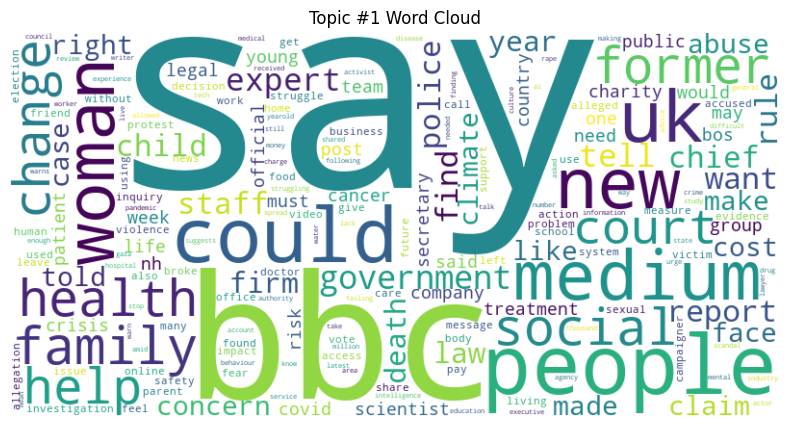

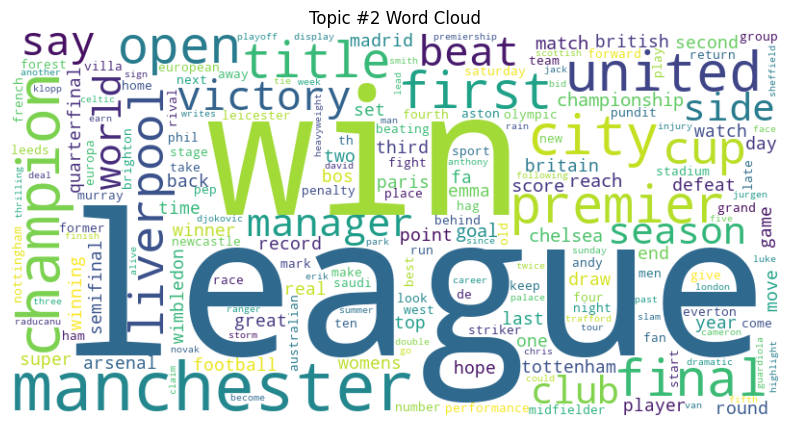

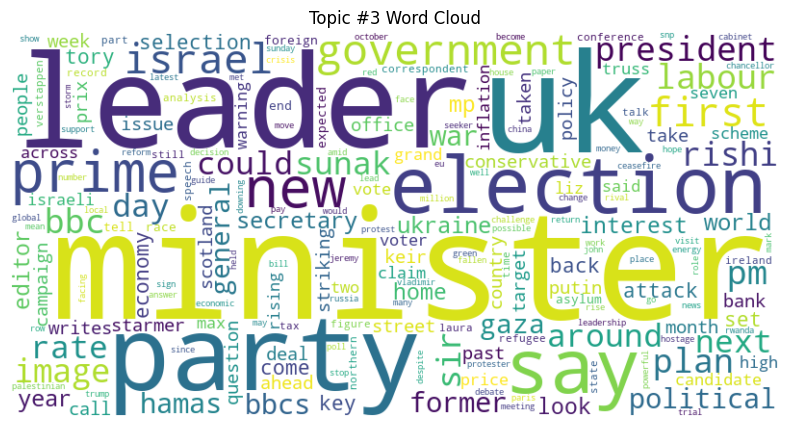

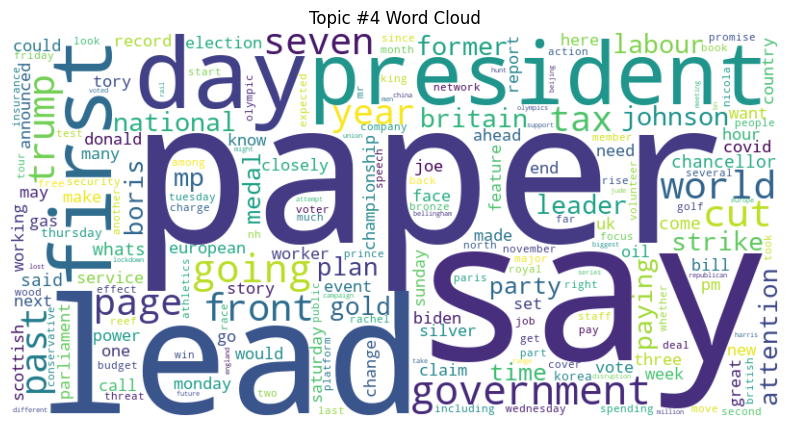

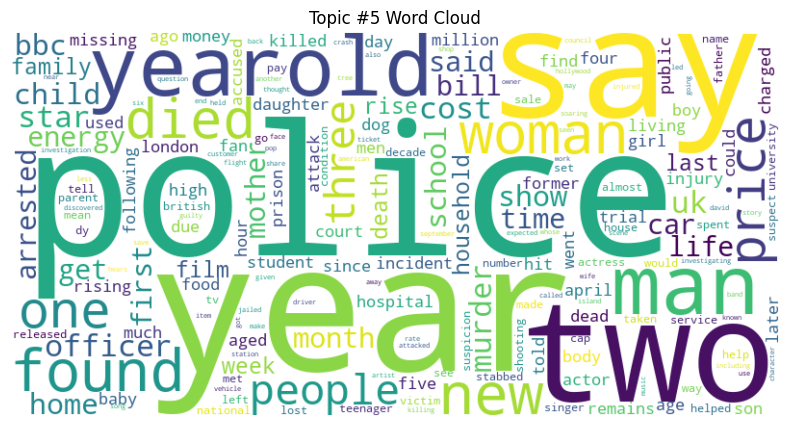

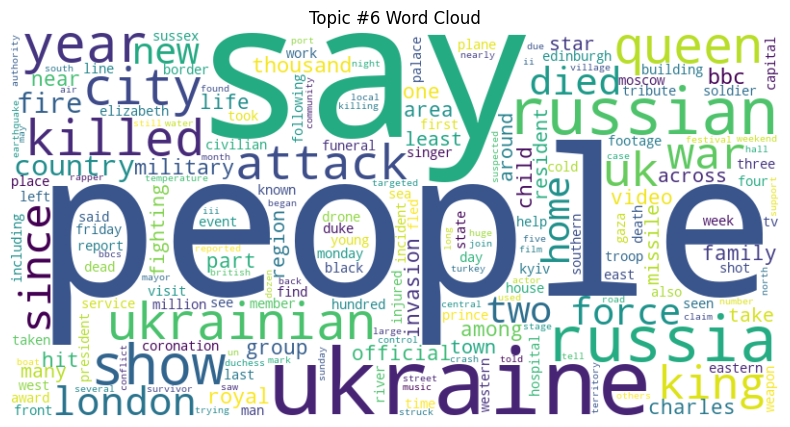

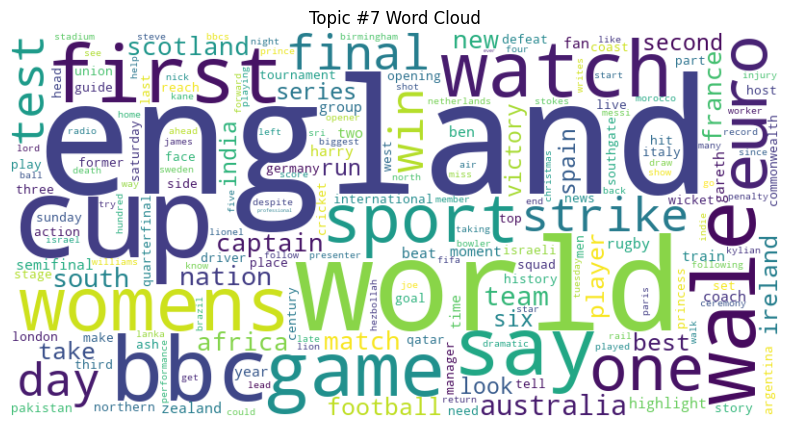

In [34]:
# Bonus
# semi-generalized function to generate word cloud for a topic
def plot_word_cloud(lda_model, topic_idx):
    topic_weights = lda_model.components_[topic_idx]
    word_weights = dict(zip(bow.get_feature_names_out(), topic_weights))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic #{topic_idx+1} Word Cloud')
    plt.show()

# Plot word cloud for all Topics here
for i in range(len(lda.components_)):
    plot_word_cloud(lda, topic_idx=i)

In [35]:
# Saved the results for a better side-by-side comparison rather than inside the notebook
pyLDAvis.save_html(lda_vis, 'Visualizations/lda_visualization.html')
pyLDAvis.save_html(nmf_vis, 'Visualizations/nmf_visualizations.html')